In [1]:
import keras

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2036746664555784554
]


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import string
from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout
from keras.models import Model
from string import punctuation

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


In [4]:
def clean_str(tweet):
    """
    Cleaning of dataset
    """
    tweet = re.sub(r"\\", "", tweet)    
    tweet = re.sub(r"\'", "", tweet)    
    tweet = re.sub(r"\"", "", tweet)
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = re.sub(r'˜¥\w*','', tweet)
    tweet = re.sub(r'˜€\w*','', tweet)
    tweet = re.sub(r'˜¤\w*','', tweet)
    tweet = re.sub(r'˜ªðÿ\w*','', tweet)
    tweet = re.sub(r'ðÿ™\w*','', tweet)
    tweet = re.sub(r'\\\w*','', tweet)
    tweet = re.sub(r'±\w*','', tweet)
    tweet = re.sub(r'\w*','', tweet)
    tweet = re.sub(r'™„˜­\w*','', tweet)
    tweet = re.sub(r'ðÿ§€\w*','', tweet)
    tweet = re.sub(r'‘šðÿ¼\w*','', tweet)
    tweet = re.sub(r'ðÿ•\w*','', tweet)
    tweet = re.sub(r'€¢\w*','', tweet)
    tweet = re.sub(r'ã©\w*','', tweet) 
    tweet = re.sub(r'\w*','',tweet)
    #tweet = re.sub(r'ðŸ\x8\w','',tweet)
    return tweet.strip().lower()

In [7]:
data_train = pd.read_excel(r'C:\Users\kushal\Desktop\bennet dataset\Task 5 data\2018-E-c-En-train\2018-E-c-En-train.xlsx')

#data_train["label"] = data_train["Intensity Class"].apply(lambda x : x.split(":")[0])
#data_train = data_train["Tweet"].apply(clean_str)
data_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,â€œWorry is a down payment on a problem you ma...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [14]:
# Input Data preprocessing
data_train = pd.read_excel(r'C:\Users\kushal\Desktop\bennet dataset\Task 5 data\2018-E-c-En-train\2018-E-c-En-train.xlsx')
#data_train["label"] = data_train["Intensity Class"].apply(lambda x : x.split(":")[0])
data_train["Text"] = data_train["Tweet"].apply(clean_str)
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
#labels = []

for i in range(data_train.Text.shape[0]):
    #text1 = data_train.Tweet[i]
    text2 = data_train.Text[i]
    #text = str(text1) +""+ str(text2)
    texts.append(text2)
    #labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust',
       'Text'],
      dtype='object')
What the raw input data looks like:
              ID                                              Tweet  anger  \
0  2017-En-21441  â€œWorry is a down payment on a problem you ma...      0   
1  2017-En-31535  Whatever you decide to do make sure it makes y...      0   
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...      1   
3  2017-En-31436  Accept the challenges so that you can literall...      0   
4  2017-En-22195  My roommate: it's okay that we can't spell bec...      1   

   anticipation  disgust  fear  joy  love  optimism  pessimism  sadness  \
0             1        0     0    0     0         1          0        0   
1             0        0     0    1     1         1          0        0   
2             0        1     0    1     0         1          0        0   
3           

In [15]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#labels = to_categorical(np.asarray(labels),num_classes = 0)
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6838, 1000)


In [16]:
labels=  data_train[['anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]

In [17]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 5470 684 684
real & fake news in train,valt,test:
anger           2037
anticipation     778
disgust         2086
fear             959
joy             1970
love             564
optimism        1584
pessimism        629
sadness         1584
surprise         285
trust            286
dtype: int64
anger           256
anticipation     91
disgust         252
fear            144
joy             244
love             71
optimism        202
pessimism        86
sadness         229
surprise         32
trust            33
dtype: int64
anger           251
anticipation    109
disgust         264
fear            139
joy             263
love             65
optimism        198
pessimism        80
sadness         195
surprise         44
trust            38
dtype: int64


In [18]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [19]:
#Using Pre-trained word embeddings
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, r'C:\Users\kushal\Desktop\bennet dataset\glove6b100dtxt\glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


W0715 13:30:24.122500  9352 deprecation_wrapper.py:119] From C:\Users\kushal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Total 400000 word vectors in Glove.


In [20]:
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(11, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
modell.fit(x_train, y_train, epochs=10, batch_size=64)

modell.save('lstm.h5')

W0715 13:31:55.999464  9352 deprecation_wrapper.py:119] From C:\Users\kushal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 13:31:56.003453  9352 deprecation_wrapper.py:119] From C:\Users\kushal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 13:31:56.011432  9352 deprecation_wrapper.py:119] From C:\Users\kushal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0715 13:31:56.012429  9352 deprecation_wrapper.py:119] From C:\Users\kushal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0715 13:31:56.051326  9352 deprecation.py:506] From C:\Users\k

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1119500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
__________

In [22]:
embedding_vecor_length = 32
modelg = Sequential()
modelg.add(embedding_layer)
modelg.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
###
modelg.add(BatchNormalization())
###
modelg.add(Dense(11, activation='softmax'))
modelg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelg.summary())
modelg.fit(x_train, y_train, epochs=2, batch_size=64)
modelg.save('gru.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1119500   
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60300     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 11)                1111      
Total params: 1,181,311
Trainable params: 1,181,111
Non-trainable params: 200
_________________________________________________________________
None
Epoch 1/2
5470/5470 [==============================] - 126s 23ms/step - loss: 0.6098 - acc: 0.7871
Epoch 2/2
5470/5470 [==============================] - 144s 26ms/step - loss: 0.5391 - acc: 0.7880


C:\Users\kushal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Correct predictions: 433.0
Total number of test examples: 684
Accuracy of model1:  0.6330409356725146


C:\Users\kushal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


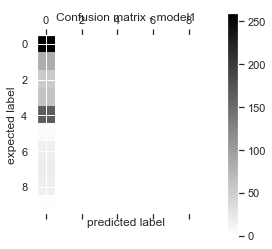

In [26]:
# Test model 1
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modell.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test.as_matrix())[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.as_matrix().argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()
#sns.set(font_scale=1)#for label size
#sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size
